# Analysis of results of inference on Moran model: compare 2 conditions

In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.utils.io as io
import delfi.summarystats as ds
import lfimodels.moran.utils as utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns

from c2st import c2st
from itertools import combinations 
from lfimodels.moran.Moran import Moran
from lfimodels.moran.MoranStats import MoranStats
from delfi.utils.viz import samples_nd
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import ranksums
from scipy.stats import mannwhitneyu
# from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold

%matplotlib inline

## model, prior, summary statistics

In [2]:
seed_p = 1
seed_m = 1
n_summary = 6

labels_params = ['Midpoint', 'Slope', 'High-to-high', 'Low-to-low', 'Baseline']

# different recordings

# original experiments
rec_WT_DMSO_exclude = ['WT_slice-'+str(i+1) for i in range(10,14)]
rec_Ts65Dn_DMSO_exclude = ['Ts65Dn_slice-'+str(i+1) for i in range(8,14)]
rec_WT = ['WT_slice-'+str(i+1) for i in range(14)]
rec_Ts65Dn = ['Ts65Dn_slice-'+str(i+1) for i in range(14)]
rec_WT = [rec for rec in rec_WT if rec not in rec_WT_DMSO_exclude]
rec_Ts65Dn = [rec for rec in rec_Ts65Dn if rec not in rec_Ts65Dn_DMSO_exclude]

# Bumetanide experiments
rec_Ts_DMSO_exclude = ['DMSO_slice-'+str(i) for i in [3,8,11,12,13,14,15,16,17,18]]
rec_Ts_Bume_exclude = ['BUME_slice-'+str(i) for i in [1,10,11,12,13,14,15,16]]
rec_Ts_DMSO = ['DMSO_slice-'+str(i+1) for i in range(19)]
rec_Ts_Bume = ['BUME_slice-'+str(i+1) for i in range(17)]
rec_Ts_DMSO = [rec for rec in rec_Ts_DMSO if rec not in rec_Ts_DMSO_exclude]
rec_Ts_Bume = [rec for rec in rec_Ts_Bume if rec not in rec_Ts_Bume_exclude]

# choose recordings to compare
rec_labels = ['WT','WT_DMSO','Ts65Dn','Ts_DMSO1','Ts_DMSO2','Ts_Bume']
all_recs = [rec_WT,rec_WT_DMSO_exclude,rec_Ts65Dn,rec_Ts65Dn_DMSO_exclude,rec_Ts_DMSO,rec_Ts_Bume]
condition1 = 4  #0 or 4
condition2 = 5  #2 or 5

rec_label_condition1 = rec_labels[condition1]
rec_label_condition2 = rec_labels[condition2]
rec_condition1 = all_recs[condition1]
rec_condition2 = all_recs[condition2]

num_rec_condition1 = len(rec_condition1)
num_rec_condition2 = len(rec_condition2)

m = Moran(seed=seed_m)
p = utils.prior(seed=seed_p)
s = MoranStats(n_summary=n_summary)

prior_min = p.lower
prior_max = p.upper
prior_lims = np.concatenate((prior_min.reshape(-1,1),prior_max.reshape(-1,1)),axis=1)

## load results

In [3]:
posterior_condition1_ls = []
# for rec in rec_condition1_changed:
for rec in rec_condition1:
    filename = './results/posterior_single_round_{rec}.pkl'.format(rec=rec)
    _, _, posterior = io.load_pkl(filename)
    posterior_condition1_ls.append(posterior)
    
posterior_condition2_ls = []
# for rec in rec_condition2_changed:
for rec in rec_condition2:
    filename = './results/posterior_single_round_{rec}.pkl'.format(rec=rec)
    _, _, posterior = io.load_pkl(filename)
    posterior_condition2_ls.append(posterior)

## sample from posteriors

In [4]:
# sample from posterior
num_samp = 100000

posterior_samples_condition1_ls = []
num_samp_condition1 = np.zeros(num_rec_condition1).astype('int')
for i in range(num_rec_condition1):
    posterior_samples = posterior_condition1_ls[i][0].gen(num_samp)

    # reject samples for which prior is zero
    ind = (posterior_samples > prior_min) & (posterior_samples < prior_max)
#     ind = 0*posterior_samples+1
    posterior_samples = posterior_samples[np.prod(ind,axis=1)==1]
    
    num_samp_condition1[i] = int(len(posterior_samples[:,0]))
    
    posterior_samples_condition1_ls.append(posterior_samples)
    print(i)
    
posterior_samples_condition2_ls = []
num_samp_condition2 = np.zeros(num_rec_condition2).astype('int')
for i in range(num_rec_condition2):
    posterior_samples = posterior_condition2_ls[i][0].gen(num_samp)

    # reject samples for which prior is zero
    ind = (posterior_samples > prior_min) & (posterior_samples < prior_max)
#     ind = 0*posterior_samples+1
    posterior_samples = posterior_samples[np.prod(ind,axis=1)==1]
    
    num_samp_condition2[i] = int(len(posterior_samples[:,0]))
    
    posterior_samples_condition2_ls.append(posterior_samples)
    print(i)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8


## exclude from analysis posteriors without samples inside prior bounds

In [5]:
num_samp_condition1

array([35009, 42905, 35760, 41174, 41478, 12186,  3356, 21333, 52343])

In [6]:
num_samp_condition2

array([   60, 63430, 44206, 26942, 26631,   825, 69971, 61786, 46824])

In [7]:
min_num = 10000
posterior_samples_condition1_subset_ls = [posterior_samples_condition1_ls[i] for i in range(num_rec_condition1) if num_samp_condition1[i]>min_num]
posterior_samples_condition1_subset_mat = np.asarray(posterior_samples_condition1_subset_ls)

posterior_samples_condition2_subset_ls =\
[posterior_samples_condition2_ls[i] for i in range(num_rec_condition2) if num_samp_condition2[i]>min_num]
posterior_samples_condition2_subset_mat = np.asarray(posterior_samples_condition2_subset_ls)

rec_condition1_subset = [rec_condition1[i] for i in range(num_rec_condition1) if num_samp_condition1[i]>min_num]
rec_condition2_subset = [rec_condition2[i] for i in range(num_rec_condition2) if num_samp_condition2[i]>min_num]

posterior_condition1_subset_ls = [posterior_condition1_ls[i] for i in range(num_rec_condition1) if num_samp_condition1[i]>min_num]
posterior_condition2_subset_ls = [posterior_condition2_ls[i] for i in range(num_rec_condition2) if num_samp_condition2[i]>min_num]

num_rec_condition1_subset = len(rec_condition1_subset)
num_rec_condition2_subset = len(rec_condition2_subset)

In [8]:
num_rec_condition1_subset

8

In [9]:
num_rec_condition2_subset

7

## basic statistics: means and standard deviations for each posterior

In [10]:
mn_posterior_condition1_ls = [np.mean(posterior_samples_condition1_subset_mat[i],0) for i in range(num_rec_condition1_subset)]
std_posterior_condition1_ls = [np.std(posterior_samples_condition1_subset_mat[i],0) for i in range(num_rec_condition1_subset)]

mn_posterior_condition2_ls = [np.mean(posterior_samples_condition2_subset_mat[i],0) for i in range(num_rec_condition2_subset)]
std_posterior_condition2_ls = [np.std(posterior_samples_condition2_subset_mat[i],0) for i in range(num_rec_condition2_subset)]


mn_posterior_condition1_mat = np.asarray(mn_posterior_condition1_ls)
std_posterior_condition1_mat = np.asarray(std_posterior_condition1_ls)

mn_posterior_condition2_mat = np.asarray(mn_posterior_condition2_ls)
std_posterior_condition2_mat = np.asarray(std_posterior_condition2_ls)

### plotting

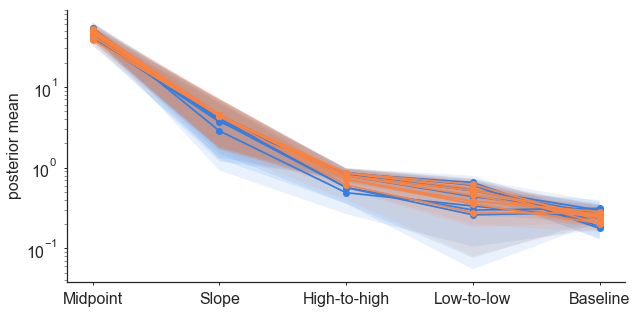

In [11]:
# colors condition1 and condition2
col_condition1 = (46/255,127/255,232/255)
col_condition2 = (252/255,130/255,62/255)
col_condition1 = sns.light_palette(col_condition1, n_colors=num_rec_condition1_subset).as_hex()
col_condition2 = sns.light_palette(col_condition2, n_colors=num_rec_condition2_subset).as_hex()

with PdfPages('Moran_all_means_'+rec_label_condition1+'_vs_'+rec_label_condition2+'.pdf') as pdf:
    fig = plt.figure(figsize=(10,5))

    num_params = 5
    xx = np.linspace(0,num_params-1,num_params)

    plt.semilogy(mn_posterior_condition1_mat.T,'o-',color=col_condition1[-1])
    plt.semilogy(mn_posterior_condition2_mat.T,'o-',color=col_condition2[-1])
    plt.ylabel('posterior mean')
    # plt.locator_params(axis='y', numticks=4)

    ax = plt.gca()
    for i in range(num_rec_condition1_subset):
        ax.fill_between(xx,
                        mn_posterior_condition1_mat[i,:]-std_posterior_condition1_mat[i,:],
                        mn_posterior_condition1_mat[i,:]+std_posterior_condition1_mat[i,:],
                        facecolor=col_condition1[-1], alpha=0.1)
    for i in range(num_rec_condition2_subset):
        ax.fill_between(xx,
                        mn_posterior_condition2_mat[i,:]-std_posterior_condition2_mat[i,:],
                        mn_posterior_condition2_mat[i,:]+std_posterior_condition2_mat[i,:],
                        facecolor=col_condition2[-1], alpha=0.1)
    ax.set_xticks(xx)
    ax.set_xticklabels(labels_params);    
    
    pdf.savefig()
#     plt.close()
    plt.show()

## logistic regression to classify samples from posteriors of the 2 conditions

In [12]:
# force to have same number of recordings in the 2 conditions
min_num_subset = np.minimum(num_rec_condition1_subset,num_rec_condition2_subset)

In [13]:
min_num_subset

7

In [14]:
posterior_samples_condition1_subset_mat2 = np.zeros((min_num_subset,min_num,num_params))
posterior_samples_condition2_subset_mat2 = np.zeros((min_num_subset,min_num,num_params))
for i in range(min_num_subset):
    posterior_samples_condition1_subset_mat2[i,:] = posterior_samples_condition1_subset_mat[i][0:min_num,:]
    
for i in range(min_num_subset):
    posterior_samples_condition2_subset_mat2[i,:] = posterior_samples_condition2_subset_mat[i][0:min_num,:]

### logistic regression with N cross-validation

In [15]:
def log_regress_cv(n_fold=10,seed=1,class_param=None,shuffle_labels=0,scoring='accuracy',fold_all_samples=True):
    
    # regression just based on particular parameters
    if class_param is not None:
        X = np.concatenate((posterior_samples_condition1_subset_mat2[:,:,class_param],
                            posterior_samples_condition2_subset_mat2[:,:,class_param]),axis=0)
    else:      
        X = np.concatenate((posterior_samples_condition1_subset_mat2,posterior_samples_condition2_subset_mat2),axis=0)
    
    # labels (classes)
    y = np.concatenate(( np.ones((min_num_subset,min_num)),2*np.ones((min_num_subset,min_num)) ))    
    
    # shuffle labels
    if shuffle_labels:
        permute_labels = list(np.random.permutation(2*min_num_subset))
        y = y[permute_labels,:]
        

    # z-score data
    X_mean = np.mean(X, axis=(0,1))
    X_std = np.std(X, axis=(0,1))
    X = (X - X_mean)/X_std
    
    if fold_all_samples:
        kf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)       
        clf = LogisticRegression(random_state=0)
        
        if class_param is not None:
            X_reshaped = X.reshape(-1,len(class_param))
        else:
            X_reshaped = X.reshape(-1,num_params)
        score = cross_val_score(clf, X_reshaped, y.reshape(-1), cv=kf, scoring=scoring)
        score = np.asarray(score)
        
    else:
        kf = KFold(n_splits=n_fold, shuffle=True, random_state=seed)

        kf.get_n_splits(X)

        i=0
        score = np.zeros(n_fold)
        for train_index, test_index in kf.split(X):

            # reshape data
            if class_param is not None:
                X_train = X[train_index].reshape(-1,len(class_param)),
                X_test = X[test_index].reshape(-1,len(class_param))
            else:
                X_train, X_test = X[train_index].reshape(-1,num_params), X[test_index].reshape(-1,num_params)
            y_train, y_test = y[train_index].reshape(-1), y[test_index].reshape(-1)

            # logistic regression and score
            clf = LogisticRegression(random_state=0).fit(X_train,y_train)

    #         if scoring=='accuracy':
            score[i] = clf.score(X_test, y_test, sample_weight=None)
    #         elif scoring=='f1_score':
    #             y_pred = clf.predict(X_test)
    #             score[i] = f1_score(y_test, y_pred, average='binary')

            i = i+1
    
    return score

### regression based on all parameters

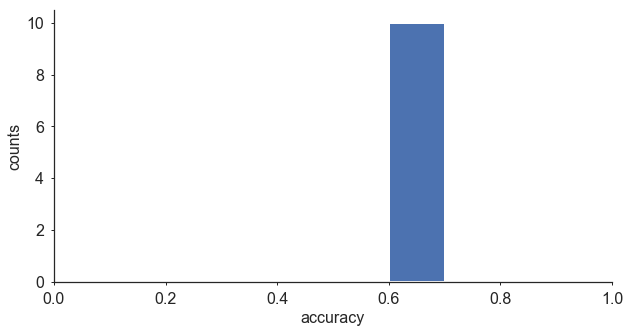

In [16]:
accuracy = log_regress_cv()

# plotting
plt.figure(figsize=(10,5))
plt.hist(accuracy,range=(0,1),ec='w',lw=2)
plt.xlim([0,1])
plt.xlabel('accuracy')
plt.ylabel('counts');

In [17]:
accuracy

array([0.63328571, 0.63664286, 0.62914286, 0.6295    , 0.63321429,
       0.63342857, 0.62871429, 0.63228571, 0.63057143, 0.63571429])

In [18]:
accuracy_original = np.mean(accuracy)

### logistic regression with shuffled data:
(1) randomise labels, do n-fold cross validation, compute the mean accuracy;

(2) repeat this procedure M (maybe 100) times;

(3) this will be an estimate of the accuracy of classification for randomised data.

In [19]:
M = 100
accuracy_shuffled = np.zeros(M)
for k in range(M):
    if (k % 25 == 0):
        print(k)
    accuracy_shuffled[k] = np.mean(log_regress_cv(shuffle_labels=1))

0
25
50
75


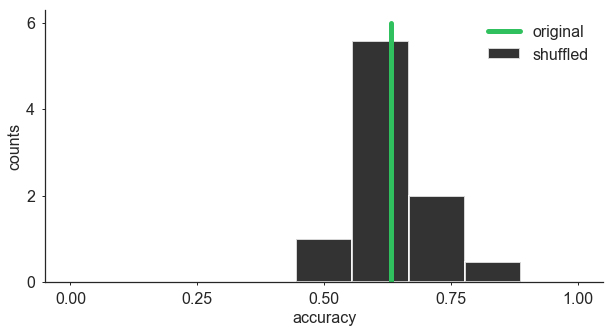

In [20]:
# plotting average accuracy for all repeats

col_original = (48/255, 192/255, 93/255)
col_shuffled = 'k'
density_hist = True
alpha_hist = .8
ec_hist = 'w'
lw_hist = 2
lw_line = lw_hist+3

bins_hist = np.linspace(0,1,10)

plt.figure(figsize=(10,5))
plt.plot(accuracy_original*np.ones(2),[0,6],color=col_original,lw=lw_line,label='original')
plt.hist(accuracy_shuffled,bins=bins_hist,normed=density_hist,
         color=col_shuffled,alpha=alpha_hist,ec=ec_hist,lw=lw_hist,label='shuffled')

plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=4)
plt.legend()
plt.xlabel('accuracy')
plt.ylabel('counts');

### test whether accuracy of classifier is significantly greater than in shuffled data

In [21]:
def log_regress_p_value(x,y):
    return (np.sum([x>=y])+1)/(len(x)+1)

In [22]:
p_value_original = log_regress_p_value(accuracy_shuffled,accuracy_original)
p_value_original

0.36633663366336633

In [23]:
accuracy_all = np.zeros(num_params+1)
accuracy_shuffled_all = np.zeros((num_params+1,M))
p_value_all = np.zeros(num_params+1)

# results of logistic regression with all parameters 
accuracy_all[0] = accuracy_original
accuracy_shuffled_all[0,:] = accuracy_shuffled
p_value_all[0] = p_value_original

### regression based on one parameter

In [24]:
for i in range(num_params):
    accuracy_all[i+1] = np.mean( log_regress_cv(class_param=[i]) )
        
    for k in range(M):
        if (k % 50 == 0):
            print(k)
        accuracy_shuffled_all[i+1,k] = np.mean( log_regress_cv(class_param=[i],shuffle_labels=1) )
        
    # p-value (one-sided)
    p_value_all[i+1] = log_regress_p_value(accuracy_shuffled_all[i+1,:],accuracy_all[i+1])

0
50
0
50
0
50
0
50
0
50


In [25]:
accuracy_all

array([0.63225   , 0.50145714, 0.53960714, 0.51167857, 0.53492857,
       0.51621429])

In [26]:
p_value_all

array([0.36633663, 0.97029703, 0.02970297, 0.9009901 , 0.75247525,
       0.85148515])

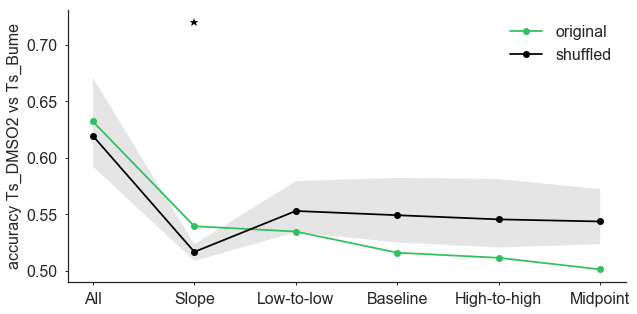

In [27]:
labels_all_and_params = np.asarray(['All']+labels_params)

# medians and IQRs
median_accuracy_shuffled_all = np.median(accuracy_shuffled_all,1)
iqr_shuffled_all = np.quantile(accuracy_shuffled_all, [0.25,.75],axis=1).T

# sorting models in decreasing accuracy
sort_params = np.argsort(accuracy_all)[::-1]

signif_all = p_value_all[sort_params]<0.05

fig = plt.figure(figsize=(10,5))
xx = np.linspace(1,num_params+1,num_params+1)
plt.plot(xx,accuracy_all[sort_params],'o-',color=col_original,label='original')
plt.plot(xx,median_accuracy_shuffled_all[sort_params],'o-',color=col_shuffled,label='shuffled')
ax = plt.gca()
ax.fill_between(xx,iqr_shuffled_all[sort_params,0],iqr_shuffled_all[sort_params,1],
                facecolor=col_shuffled, alpha=0.1)

plt.plot(xx[signif_all],xx[signif_all]*0+.72,'*',color=col_shuffled,markersize=9)
plt.ylabel('accuracy '+rec_label_condition1+' vs '+rec_label_condition2)
ax = plt.gca()
ax.set_xticks(xx)
ax.set_xticklabels(labels_all_and_params[sort_params])
plt.legend();

### regression based on all but one parameter

In [28]:
accuracy_except_all = np.zeros(num_params+1)
accuracy_shuffled_except_all = np.zeros((num_params+1,M))
p_value_except_all = np.zeros(num_params+1)

# results of regression with all parameters 
accuracy_except_all[0] = accuracy_original
accuracy_shuffled_except_all[0,:] = accuracy_shuffled
p_value_except_all[0] = p_value_original

In [29]:
from itertools import combinations 

comb = list(combinations(np.arange(0,num_params,1), num_params-1))
num_comb = len(comb)

for i in range(num_comb):
    accuracy_except_all[i+1] = np.mean( log_regress_cv(class_param=comb[i]) )
        
    for k in range(M):
        if (k % 50 == 0):
            print(k)
        accuracy_shuffled_except_all[i+1,k] = np.mean( log_regress_cv(class_param=comb[i],shuffle_labels=1) )
        
    # p-value (one-sided)
    p_value_except_all[i+1] = log_regress_p_value(accuracy_shuffled_except_all[i+1,:],accuracy_except_all[i+1])

0
50
0
50
0
50
0
50
0
50


In [30]:
p_value_except_all

array([0.36633663, 0.32673267, 0.83168317, 0.40594059, 0.45544554,
       0.61386139])

In [31]:
comb_miss = []
for i in range(num_params):
    comb_miss.append([x for x in np.arange(0,num_params,1) if x not in comb[i]])
    
comb_miss = np.reshape(comb_miss,-1).astype('int')

labels_params_except = ['\\'+x for x in labels_params]
labels_params_except = list(np.asarray(labels_params_except)[comb_miss])

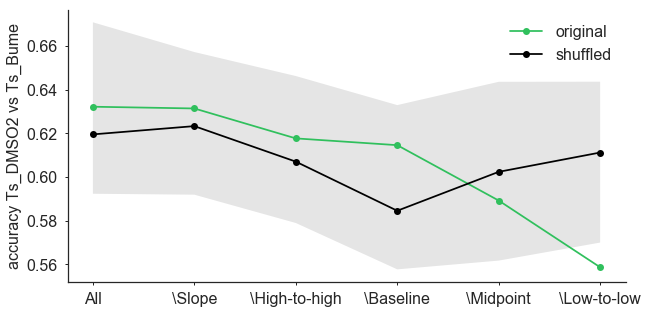

In [32]:
labels_all_and_params = np.asarray(['All']+labels_params_except)

# medians and IQRs
median_accuracy_shuffled_all = np.median(accuracy_shuffled_except_all,1)
iqr_shuffled_all = np.quantile(accuracy_shuffled_except_all, [0.25,.75],axis=1).T

# sorting models in decreasing accuracy
sort_params = np.argsort(accuracy_except_all)[::-1]

signif_all = p_value_except_all[sort_params]<0.05

fig = plt.figure(figsize=(10,5))
xx = np.linspace(1,num_params+1,num_params+1)
plt.plot(xx,accuracy_except_all[sort_params],'o-',color=col_original,label='original')
plt.plot(xx,median_accuracy_shuffled_all[sort_params],'o-',color=col_shuffled,label='shuffled')
ax = plt.gca()
ax.fill_between(xx,iqr_shuffled_all[sort_params,0],iqr_shuffled_all[sort_params,1],
                facecolor=col_shuffled, alpha=0.1)

plt.plot(xx[signif_all],xx[signif_all]*0+.72,'*',color=col_shuffled,markersize=9)
plt.ylabel('accuracy '+rec_label_condition1+' vs '+rec_label_condition2)
ax = plt.gca()
ax.set_xticks(xx)
ax.set_xticklabels(labels_all_and_params[sort_params])
plt.legend();

## PERMANOVA

In [574]:
import skbio

In [683]:
def zscore_data(X):
    # z-score data
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    return (X - X_mean)/X_std

In [719]:
# prepare distance matrix
from scipy.spatial import distance_matrix

X_condition1 = posterior_samples_condition1_subset_mat2.reshape(-1,num_params)
X_condition2 = posterior_samples_condition2_subset_mat2.reshape(-1,num_params)

# z-score data
X_condition1 = zscore_data(X_condition1)
X_condition1 = zscore_data(X_condition1)

# permute samples
num_subsample = 1000
permute_samples_condition1 = list(np.random.choice(min_num, num_subsample, replace=False))
permute_samples_condition2 = list(np.random.choice(min_num, num_subsample, replace=False))

X_subsample = np.concatenate((X_condition1[permute_samples_condition1,:],
                              X_condition2[permute_samples_condition2,:]),axis=0)

dist_mat1 = distance_matrix(X_subsample,X_subsample)
dist_mat = skbio.DistanceMatrix(dist_mat1)

In [720]:
grouping = [rec_label_condition1]*num_subsample+[rec_label_condition2]*num_subsample
column = None
permutations = 99
permanova_all = skbio.stats.distance.permanova(distance_matrix=dist_mat, grouping=grouping,
                                               column=column, permutations=permutations)

In [721]:
permanova_all

method name               PERMANOVA
test statistic name        pseudo-F
sample size                    2000
number of groups                  2
test statistic              34087.4
p-value                        0.01
number of permutations           99
Name: PERMANOVA results, dtype: object

In [722]:
param_ind = 0
X_subsample_1param = np.concatenate((X_condition1[permute_samples_condition1,param_ind],
                                     X_condition2[permute_samples_condition2,param_ind]),axis=0)

dist_mat1 = distance_matrix(X_subsample_1param.reshape(-1,1),X_subsample_1param.reshape(-1,1))
dist_mat_1param = skbio.DistanceMatrix(dist_mat1)

permanova_1param = skbio.stats.distance.permanova(distance_matrix=dist_mat_1param,
                                                  grouping=grouping, column=column, permutations=permutations)

In [723]:
permanova_1param

method name               PERMANOVA
test statistic name        pseudo-F
sample size                    2000
number of groups                  2
test statistic              40810.9
p-value                        0.01
number of permutations           99
Name: PERMANOVA results, dtype: object

In [724]:
param_ind = 1
X_subsample_1param = np.concatenate((X_condition1[permute_samples_condition1,param_ind],
                                     X_condition2[permute_samples_condition2,param_ind]),axis=0)

dist_mat1 = distance_matrix(X_subsample_1param.reshape(-1,1),X_subsample_1param.reshape(-1,1))
dist_mat_1param = skbio.DistanceMatrix(dist_mat1)

permanova_1param = skbio.stats.distance.permanova(distance_matrix=dist_mat_1param,
                                                  grouping=grouping, column=column, permutations=permutations)

In [725]:
permanova_1param

method name               PERMANOVA
test statistic name        pseudo-F
sample size                    2000
number of groups                  2
test statistic              2418.94
p-value                        0.01
number of permutations           99
Name: PERMANOVA results, dtype: object

In [726]:
param_ind = 2
X_subsample_1param = np.concatenate((X_condition1[permute_samples_condition1,param_ind],
                                     X_condition2[permute_samples_condition2,param_ind]),axis=0)

dist_mat1 = distance_matrix(X_subsample_1param.reshape(-1,1),X_subsample_1param.reshape(-1,1))
dist_mat_1param = skbio.DistanceMatrix(dist_mat1)

permanova_1param = skbio.stats.distance.permanova(distance_matrix=dist_mat_1param,
                                                  grouping=grouping, column=column, permutations=permutations)

In [727]:
permanova_1param

method name               PERMANOVA
test statistic name        pseudo-F
sample size                    2000
number of groups                  2
test statistic              392.565
p-value                        0.01
number of permutations           99
Name: PERMANOVA results, dtype: object

In [728]:
param_ind = 3
X_subsample_1param = np.concatenate((X_condition1[permute_samples_condition1,param_ind],
                                     X_condition2[permute_samples_condition2,param_ind]),axis=0)

dist_mat1 = distance_matrix(X_subsample_1param.reshape(-1,1),X_subsample_1param.reshape(-1,1))
dist_mat_1param = skbio.DistanceMatrix(dist_mat1)

permanova_1param = skbio.stats.distance.permanova(distance_matrix=dist_mat_1param,
                                                  grouping=grouping, column=column, permutations=permutations)

In [729]:
permanova_1param

method name               PERMANOVA
test statistic name        pseudo-F
sample size                    2000
number of groups                  2
test statistic              12.8859
p-value                        0.01
number of permutations           99
Name: PERMANOVA results, dtype: object

In [730]:
param_ind = 4
X_subsample_1param = np.concatenate((X_condition1[permute_samples_condition1,param_ind],
                                     X_condition2[permute_samples_condition2,param_ind]),axis=0)

dist_mat1 = distance_matrix(X_subsample_1param.reshape(-1,1),X_subsample_1param.reshape(-1,1))
dist_mat_1param = skbio.DistanceMatrix(dist_mat1)

permanova_1param = skbio.stats.distance.permanova(distance_matrix=dist_mat_1param,
                                                  grouping=grouping, column=column, permutations=permutations)

In [731]:
permanova_1param

method name               PERMANOVA
test statistic name        pseudo-F
sample size                    2000
number of groups                  2
test statistic              308.772
p-value                        0.01
number of permutations           99
Name: PERMANOVA results, dtype: object

## redo logistic regression on all data

In [25]:
# logistic regression without cross-validation
X1 = posterior_samples_condition1_subset_mat2.reshape(-1,num_params)
X2 = posterior_samples_condition2_subset_mat2.reshape(-1,num_params)     
X = np.concatenate((X1,X2))

y = np.concatenate( (np.ones(min_num*min_num_subset),2*np.ones(min_num*min_num_subset)) )

clf_no_cv = LogisticRegression(random_state=0).fit(X,y)
pred_y = clf_no_cv.predict(X)

conf_mat = confusion_matrix(y, pred_y)
conf_mat_total = np.sum(conf_mat)

accuracy_no_cv = (conf_mat[0,0]+conf_mat[1,1])/conf_mat_total 

## project decision boundary to 1D or 2D with expectations given posterior

In [26]:
# clf_no_cv.predict(np.mean(mn_posterior_condition1_mat[0:min_num_subset],0))

In [27]:
# # expected value given all posteriors
# expect_param = np.mean(mn_posterior_condition1_mat[0:min_num_subset],0)
# n_samp = 100
# decision_boundary = np.zeros(n_samp)

# for i in range(num_params):
#     for j in range(num_params):
        

# # decision_bound =

## plot posteriors and decision boundary of logistic regression for baseline parameter

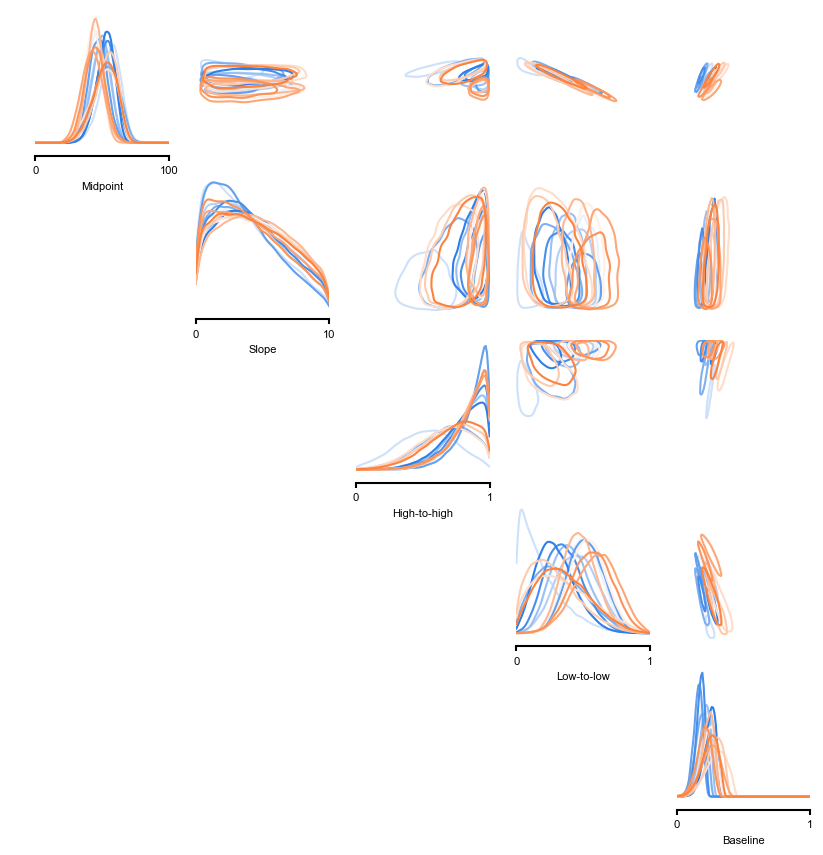

In [28]:
col_contrs = col_condition1+col_condition2

with PdfPages('Moran_all_posteriors_'+rec_label_condition1+'_vs_'+rec_label_condition2+'.pdf') as pdf:
    fig, axes = samples_nd(posterior_samples_condition1_subset_ls+posterior_samples_condition2_subset_ls, 
                           samples_colors=col_contrs,
                           title='',
                           upper='contour', 
                           diag='kde',
                           limits=prior_lims,
                           ticks=prior_lims,
                           labels=labels_params,
                           fig_size=(10,10),
                           kde_offdiag={'bins': 100},
                           contour_offdiag={'levels': [0.68]});
    
    pdf.savefig()
#     plt.close()
    plt.show()

## projection of posterior samples into squared double-well potential

In [241]:
# def double_well(samples,p):
#     samples1 = 1*samples
    
#     # midpoint between -1 and 1
#     samples1[:,0] = ( 2*samples1[:,0]-(p.upper[0]+p.lower[0]) )/(p.upper[0]-p.lower[0])
    
#     # slope between 2 and 3
#     slp_min = 2
#     slp_max = 6
#     samples1[:,1] = ( (slp_max-slp_min)*samples[:,1]+(slp_min*p.upper[0]-slp_max*p.lower[0]) )/(p.upper[0]-p.lower[0])
    
#     # X range [-range_fact,range_fact]
#     range_fact = 2;
#     X1 = np.linspace(-range_fact*samples1[:,3],range_fact*samples1[:,2],20)
#     X = np.concatenate((-range_fact*samples1[:,3]+0*X1,X1,range_fact*samples1[:,2]+0*X1),axis=0)
    
#     # output before normalizing to maximum
#     out1 = -np.abs(X1-samples1[:,0])**samples1[:,1]
    
#     out = np.concatenate(((1-samples1[:,4])+0*out1,out1,samples1[:,4]+0*out1),axis=0)
#     return X, out

In [296]:
def double_well(samples,p):
    
    num_samp = len(samples)
    
    # midpoint between -1 and 1
    x_midpoint = ( 2*samples[:,0]-(p.upper[0]+p.lower[0]) )/(p.upper[0]-p.lower[0])
    
    # slope between 2 and 3
    slp_min = 3
    slp_max = 6
    slopes = ( (slp_max-slp_min)*samples[:,1]+(slp_min*p.upper[0]-slp_max*p.lower[0]) )/(p.upper[0]-p.lower[0])
    
    # depth low2low and high2high
    y_l2l = -samples[:,3]
    y_h2h = -samples[:,2]
    
    # midpoint y-coordinate
    y_midpoint = np.ones(num_samp)
    
    # coordinates of intersection between wells and hill
    # y_intercept = y_midpoint -/+ slope*x_midpoint
    # x = (y-y_intercept)/slope
    y_intercept_l2l = y_midpoint - slopes*x_midpoint
    y_intercept_h2h = y_midpoint + slopes*x_midpoint
    x_intersect_l2l = (y_l2l-y_intercept_l2l)/slopes
    x_intersect_h2h = (y_h2h-y_intercept_h2h)/(-slopes)
    
    # x range [-1,1]  
    x = np.concatenate((-np.ones(num_samp).reshape(-1,1),
                        x_intersect_l2l.reshape(-1,1),
                        x_midpoint.reshape(-1,1),
                        x_intersect_h2h.reshape(-1,1),
                        np.ones(num_samp).reshape(-1,1)),axis=1)
    
    # output
    out = np.concatenate((y_l2l.reshape(-1,1),
                          y_l2l.reshape(-1,1),
                          y_midpoint.reshape(-1,1),
                          y_h2h.reshape(-1,1),
                          y_h2h.reshape(-1,1)),axis=1)
    
    return x, out

In [308]:
# projection
dw_x_condition1, dw_out_condition1 = double_well(posterior_samples_condition1_subset_mat[0],p)
dw_x_condition2, dw_out_condition2 = double_well(posterior_samples_condition2_subset_mat[0],p)

dw_out_condition1_mn = np.mean(dw_out_condition1,axis=0)
dw_out_condition2_mn = np.mean(dw_out_condition2,axis=0)
dw_out_condition1_std = np.std(dw_out_condition1,axis=0)
dw_out_condition2_std = np.std(dw_out_condition2,axis=0)

dw_x_condition1_mn = np.mean(dw_x_condition1,axis=0)
dw_x_condition2_mn = np.mean(dw_x_condition2,axis=0)
dw_x_condition1_std = np.std(dw_x_condition1,axis=0)
dw_x_condition2_std = np.std(dw_x_condition2,axis=0)

baseline_condition1_mn = np.mean(posterior_samples_condition1_subset_mat[0][:,4])
baseline_condition1_std = np.std(posterior_samples_condition1_subset_mat[0][:,4])
baseline_condition2_mn = np.mean(posterior_samples_condition2_subset_mat[0][:,4])
baseline_condition2_std = np.std(posterior_samples_condition2_subset_mat[0][:,4])

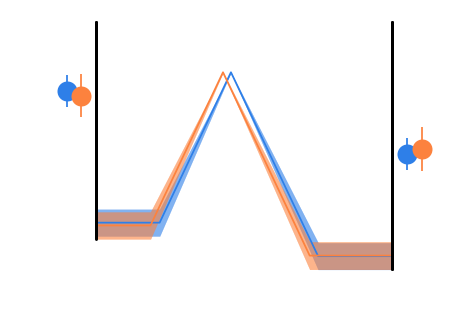

In [341]:
# plotting
# X = np.concatenate((-np.ones(2),np.ones(2)),axis=0)
fig = plt.figure(figsize=(7,5))

# plot means+/-stds of squared double-well
plt.plot(dw_x_condition1_mn,dw_out_condition1_mn,color=col_condition1[-1],label=rec_label_condition1)
plt.plot(dw_x_condition2_mn,dw_out_condition2_mn,color=col_condition2[-1],label=rec_label_condition2)
ax = plt.gca()
ax.fill_between(dw_x_condition1_mn,dw_out_condition1_mn-dw_out_condition1_std,
                dw_out_condition1_mn+dw_out_condition1_std,
                color=col_condition1[-1], alpha=0.6)
ax.fill_between(dw_x_condition2_mn,dw_out_condition2_mn-dw_out_condition2_std,
                dw_out_condition2_mn+dw_out_condition2_std,
                color=col_condition2[-1], alpha=0.6);

# plot baseline
x_baseline = np.array([-1.2,-1.1,1.1,1.2])
plt.errorbar(x_baseline[0], 1-baseline_condition1_mn,marker='.',markersize=40,
             yerr=4*baseline_condition1_std,color=col_condition1[-1])
plt.errorbar(x_baseline[1], 1-baseline_condition2_mn,marker='.',markersize=40,
             yerr=4*baseline_condition2_std,color=col_condition2[-1])
plt.errorbar(x_baseline[2], baseline_condition1_mn,marker='.',markersize=40,
             yerr=4*baseline_condition1_std,color=col_condition1[-1])
plt.errorbar(x_baseline[3], baseline_condition2_mn,marker='.',markersize=40,
             yerr=4*baseline_condition2_std,color=col_condition2[-1])

# plot walls
plt.plot(-np.ones(2),np.array([dw_out_condition1_mn[0]-dw_out_condition1_std[0],1.5]),color='k',lw=3)
plt.plot(np.ones(2),np.array([dw_out_condition1_mn[-1]-dw_out_condition1_std[-1],1.5]),color='k',lw=3)
plt.plot(-np.ones(2),np.array([dw_out_condition2_mn[0]-dw_out_condition2_std[0],1.5]),color='k',lw=3)
plt.plot(np.ones(2),np.array([dw_out_condition2_mn[-1]-dw_out_condition2_std[-1],1.5]),color='k',lw=3)

plt.axis('off');

## from here on, it is old material!!

In [21]:
X = np.concatenate((posterior_samples_condition1_subset_mat2,posterior_samples_condition2_subset_mat2))
y = np.concatenate((np.ones(min_num*min_num_subset),2*np.ones(min_num*min_num_subset)))
X_test = np.concatenate((posterior_samples_condition1_subset_test2,posterior_samples_condition2_subset_test2))
y_test = np.concatenate((np.ones(len(posterior_samples_condition1_subset_test2)),
                         2*np.ones(len(posterior_samples_condition2_subset_test2))))

clf = LogisticRegression(random_state=0).fit(X, y)

pred_y_test = clf.predict(X_test)
# pred_probs = clf.predict_proba(X_test)

## accuracy for logistic regression with different parameters

### (1) logistic regression with all parameters or a single parameter

In [22]:
conf_mat_all = confusion_matrix(y_test, pred_y_test)
conf_mat_all_total = np.sum(conf_mat_all)
accuracy_all = (conf_mat_all[0,0]+conf_mat_all[1,1])/conf_mat_all_total

accuracy_1param = np.zeros(num_params)
for k in range(num_params):
    clf_1param = LogisticRegression(random_state=0).fit(X[:,k].reshape(-1,1), y)
    pred_y_test_1param = clf_1param.predict(X_test[:,k].reshape(-1,1))

    conf_mat_1param = confusion_matrix(y_test, pred_y_test_1param)
    total_1param = np.sum(conf_mat_1param)

    accuracy_1param[k] = (conf_mat_1param[0,0]+conf_mat_1param[1,1])/total_1param

accuracy_all_and_1param = np.concatenate((np.array([accuracy_all]),accuracy_1param))
labels_all_and_params = np.asarray(['All']+labels_params)
sort_params = np.argsort(accuracy_all_and_1param)[::-1]

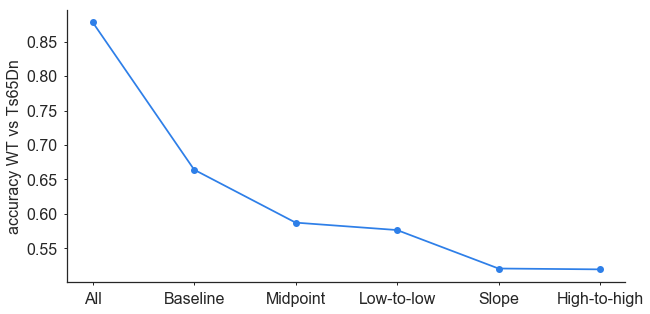

In [23]:
with PdfPages('Moran_accuracy_'+rec_label_condition1+'_vs_'+rec_label_condition2+'.pdf') as pdf:
    fig = plt.figure(figsize=(10,5))
    xx = np.linspace(1,num_params+1,num_params+1)
    plt.plot(xx,accuracy_all_and_1param[sort_params],'o-',color=col_condition1[-1])
    plt.ylabel('accuracy '+rec_label_condition1+' vs '+rec_label_condition2)
    ax = plt.gca()
    ax.set_xticks(xx)
    ax.set_xticklabels(labels_all_and_params[sort_params]);

    pdf.savefig()
#     plt.close()
    plt.show()

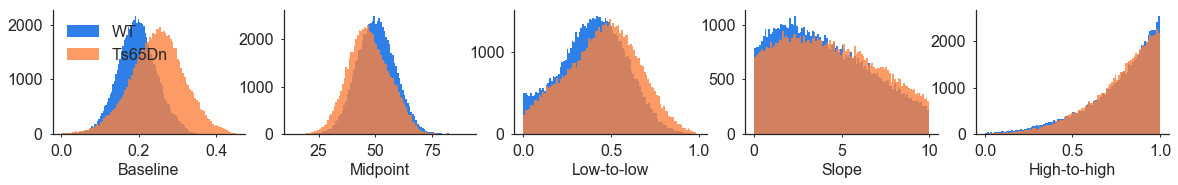

In [24]:
fig = plt.figure(figsize=(20,5))
i=1
for k in sort_params[1:]-1:
    plt.subplot(2,5,i)
    plt.hist(X[y==1,k],color=col_condition1[-1],label=rec_label_condition1,bins=100)
    plt.hist(X[y==2,k],color=col_condition2[-1],alpha=0.8,label=rec_label_condition2,bins=100)
    plt.xlabel(labels_params[k])
    if i==1:
        plt.legend()
    i+=1

### (1a) logistic regression with observed summary statistics

In [25]:
obs_stats_condition1_ls = []
for rec in rec_condition1_subset:
    obs = utils.LTP_obs_data(rec=rec)
    obs_stats = utils.LTP_obs_stats(rec=rec)
    obs_stats_condition1_ls.append(obs_stats[0])
obs_stats_condition1_mat = np.asarray(obs_stats_condition1_ls)
    
obs_stats_condition2_ls = []
for rec in rec_condition2_subset:
    obs = utils.LTP_obs_data(rec=rec)
    obs_stats = utils.LTP_obs_stats(rec=rec)
    obs_stats_condition2_ls.append(obs_stats[0])
obs_stats_condition2_mat = np.asarray(obs_stats_condition2_ls)


X_obs = np.concatenate((obs_stats_condition1_mat,obs_stats_condition2_mat))
y_obs = np.concatenate((np.ones(len(rec_condition1_subset)),2*np.ones(len(rec_condition2_subset))))

clf_obs = LogisticRegression(random_state=0).fit(X_obs, y_obs)

pred_y_obs = clf_obs.predict(X_obs)


conf_mat_obs = confusion_matrix(y_obs, pred_y_obs)
conf_mat_obs_total = np.sum(conf_mat_obs)
accuracy_obs = (conf_mat_obs[0,0]+conf_mat_obs[1,1])/conf_mat_obs_total

accuracy_obs

0.6

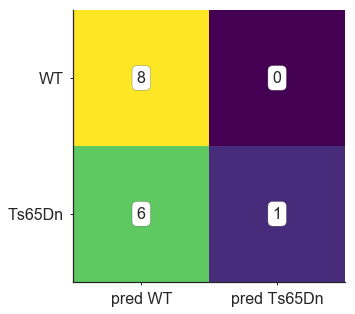

In [26]:
fig = plt.figure(figsize=(10,5))
plt.imshow(conf_mat_obs, cmap='viridis')

ax = plt.gca()
for (i, j), z in np.ndenumerate(conf_mat_obs):
    ax.text(j, i, str(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['pred '+rec_label_condition1,'pred '+rec_label_condition2])
ax.set_yticklabels([rec_label_condition1,rec_label_condition2]);

### (2) analysis per recording: all 1st conditions vs one 2nd condition

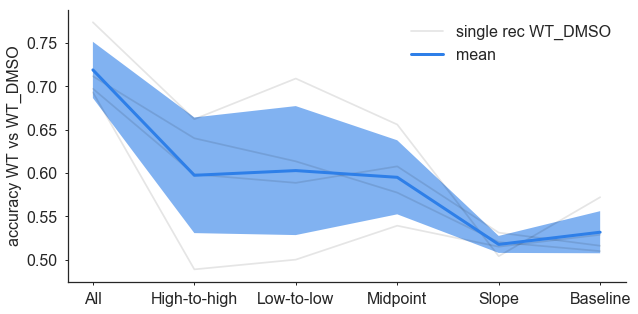

In [27]:
# subsample all condition1 posteriors, to get same or almost same number of samples as for one condition2 posterior
num_samples_all = len(posterior_samples_condition1_subset_mat2)
ind_condition1_samples_all = np.random.choice(num_samples_all, min_num, replace=False)
condition1_samples_all = posterior_samples_condition1_subset_mat2[ind_condition1_samples_all,:]

num_samples_all_test = len(posterior_samples_condition1_subset_test2)
ind_condition1_samples_all_test = np.random.choice(num_samples_all_test, min_num, replace=False)
condition1_samples_all_test = posterior_samples_condition1_subset_mat2[ind_condition1_samples_all_test,:]

xx = np.linspace(1,num_params+1,num_params+1)

# logistic regression all condition1 vs condition2
accuracy_all_and_1param_rec = np.zeros((min_num_subset,num_params+1))
# for i in range(num_rec_condition2_subset):
for i in range(min_num_subset):
    X_allcondition1_1Ts = np.concatenate((condition1_samples_all,posterior_samples_condition2_subset_mat[i][0:min_num,:]))
    y_allcondition1_1Ts = np.concatenate((np.ones(min_num),2*np.ones(min_num)))
    X_allcondition1_1Ts_test = np.concatenate((condition1_samples_all_test,posterior_samples_condition2_subset_test[i]))
    y_allcondition1_1Ts_test = np.concatenate((np.ones(len(condition1_samples_all_test)),
                             2*np.ones(len(posterior_samples_condition2_subset_test[i]))))

    clf = LogisticRegression(random_state=0).fit(X_allcondition1_1Ts, y_allcondition1_1Ts)
    pred_y_allcondition1_1Ts_test = clf.predict(X_allcondition1_1Ts_test)
    
    conf_mat_all = confusion_matrix(y_allcondition1_1Ts_test, pred_y_allcondition1_1Ts_test)
    conf_mat_all_total = np.sum(conf_mat_all)
    accuracy_all = (conf_mat_all[0,0]+conf_mat_all[1,1])/conf_mat_all_total

    # accuracy for logistic regression with different parameters
    accuracy_1param = np.zeros(num_params)
    for k in range(num_params):
        clf_1param = LogisticRegression(random_state=0).fit(X_allcondition1_1Ts[:,k].reshape(-1,1), y_allcondition1_1Ts)
        pred_y_test_1param = clf_1param.predict(X_allcondition1_1Ts_test[:,k].reshape(-1,1))

        conf_mat_1param = confusion_matrix(y_allcondition1_1Ts_test, pred_y_test_1param)
        total_1param = np.sum(conf_mat_1param)

        accuracy_1param[k] = (conf_mat_1param[0,0]+conf_mat_1param[1,1])/total_1param

    accuracy_all_and_1param_rec[i,:] = np.concatenate((np.array([accuracy_all]),accuracy_1param))
    
    
# plotting
fig = plt.figure(figsize=(10,5))
mn_accuracy = np.mean(accuracy_all_and_1param_rec[:,sort_params],0)
std_accuracy = np.std(accuracy_all_and_1param_rec[:,sort_params],0)
plt.plot(xx,accuracy_all_and_1param_rec[:-1,sort_params].T,'k', alpha=0.1)
plt.plot(xx,accuracy_all_and_1param_rec[-1,sort_params],'k', alpha=0.1, label='single rec '+rec_label_condition2)
plt.plot(xx,mn_accuracy,color=col_condition1[-1],lw=3, label='mean')
ax = plt.gca()
ax.fill_between(xx,
                mn_accuracy-std_accuracy,
                mn_accuracy+std_accuracy,
                facecolor=col_condition1[-1], alpha=0.6)
plt.ylabel('accuracy '+rec_label_condition1+' vs '+rec_label_condition2)
ax = plt.gca()
ax.set_xticks(xx)
ax.set_xticklabels(labels_all_and_params[sort_params]);
plt.legend();

### (3) logistic regression with all parameters or pairs of parameters

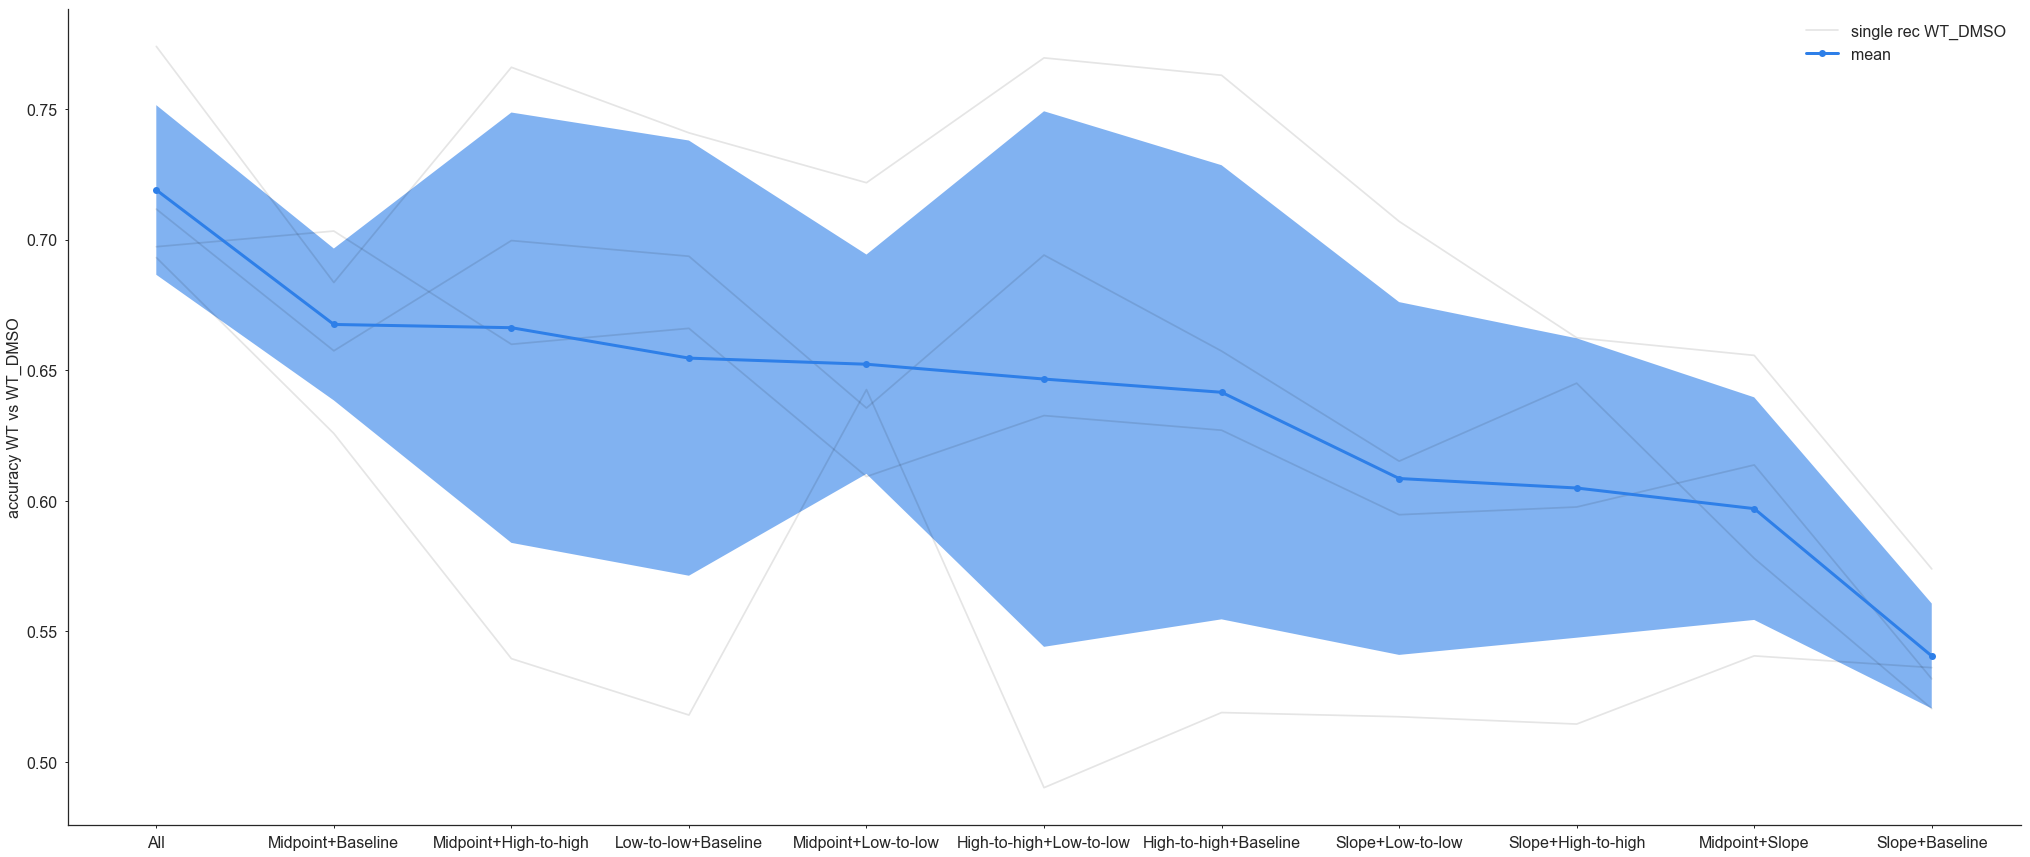

In [28]:
from itertools import combinations 

comb = list(combinations([0,1,2,3,4], 2))
num_comb = len(comb)

xx = np.linspace(1,num_comb+1,num_comb+1)

# logistic regression all 1st condition vs 2nd condition
accuracy_all_and_2param_rec = np.zeros((min_num_subset,num_comb+1))
# for i in range(num_rec_condition2_subset):
for i in range(min_num_subset):
    X_allcondition1_1Ts = np.concatenate((condition1_samples_all,posterior_samples_condition2_subset_mat[i][0:min_num,:]))
    y_allcondition1_1Ts = np.concatenate((np.ones(min_num),2*np.ones(min_num)))
    X_allcondition1_1Ts_test = np.concatenate((condition1_samples_all_test,posterior_samples_condition2_subset_test[i]))
    y_allcondition1_1Ts_test = np.concatenate((np.ones(len(condition1_samples_all_test)),
                             2*np.ones(len(posterior_samples_condition2_subset_test[i]))))

    clf = LogisticRegression(random_state=0).fit(X_allcondition1_1Ts, y_allcondition1_1Ts)
    pred_y_allcondition1_1Ts_test = clf.predict(X_allcondition1_1Ts_test)
    
    conf_mat_all = confusion_matrix(y_allcondition1_1Ts_test, pred_y_allcondition1_1Ts_test)
    conf_mat_all_total = np.sum(conf_mat_all)
    accuracy_all = (conf_mat_all[0,0]+conf_mat_all[1,1])/conf_mat_all_total

    # accuracy for logistic regression with different parameters
    accuracy_2param = np.zeros(num_comb)
    for k in range(num_comb):
        clf_2param = LogisticRegression(random_state=0).fit(X_allcondition1_1Ts[:,comb[k]], y_allcondition1_1Ts)
        pred_y_test_2param = clf_2param.predict(X_allcondition1_1Ts_test[:,comb[k]])

        conf_mat_2param = confusion_matrix(y_allcondition1_1Ts_test, pred_y_test_2param)
        total_2param = np.sum(conf_mat_2param)

        accuracy_2param[k] = (conf_mat_2param[0,0]+conf_mat_2param[1,1])/total_2param

    accuracy_all_and_2param_rec[i,:] = np.concatenate((np.array([accuracy_all]),accuracy_2param))
    
    
labels_2params = [labels_params[kk[0]]+'+'+labels_params[kk[1]] for kk in comb]
labels_all_and_2params = np.asarray(['All']+labels_2params)

mn_accuracy = np.mean(accuracy_all_and_2param_rec,0)
std_accuracy = np.std(accuracy_all_and_2param_rec,0)
sort_mn_accuracy = np.argsort(mn_accuracy)[::-1]

fig = plt.figure(figsize=(35,15))
plt.plot(xx,accuracy_all_and_2param_rec[:-1,sort_mn_accuracy].T,'k', alpha=0.1)
plt.plot(xx,accuracy_all_and_2param_rec[-1,sort_mn_accuracy],'k', alpha=0.1, label='single rec '+rec_label_condition2)
plt.plot(xx,mn_accuracy[sort_mn_accuracy],'-o',color=col_condition1[-1],lw=3, label='mean')
ax = plt.gca()
ax.fill_between(xx,
                mn_accuracy[sort_mn_accuracy]-std_accuracy[sort_mn_accuracy],
                mn_accuracy[sort_mn_accuracy]+std_accuracy[sort_mn_accuracy],
                facecolor=col_condition1[-1], alpha=0.6)
plt.ylabel('accuracy '+rec_label_condition1+' vs '+rec_label_condition2)
ax = plt.gca()
ax.set_xticks(xx)
ax.set_xticklabels(labels_all_and_2params[sort_mn_accuracy]);
plt.legend();

## plot posteriors

In [ ]:
col_contrs = col_condition1+col_condition2

with PdfPages('Moran_all_posteriors_'+rec_label_condition1+'_vs_'+rec_label_condition2+'.pdf') as pdf:
    fig, axes = samples_nd(posterior_samples_condition1_subset_ls+posterior_samples_condition2_subset_ls, 
                           samples_colors=col_contrs,
                           title='',
                           upper='contour', 
                           diag='kde',
                           limits=prior_lims,
                           ticks=prior_lims,
                           labels=labels_params,
                           fig_size=(10,10),
                           kde_offdiag={'bins': 100},
                           contour_offdiag={'levels': [0.68]});
    
    pdf.savefig()
#     plt.close()
    plt.show()

## some simulations

### pick the 3 samples with highest probability under each posterior

In [29]:
num_samp_subset = 3
num_params = len(labels_params)

posterior_samples_condition1_3sets = np.zeros((num_samp_subset,num_params,min_num_subset))
j=0
for i in range(num_rec_condition1):
    if num_samp_condition1[i]>min_num and j<min_num_subset:
        ind_hi_prob_snpe = np.argsort(posterior_condition1_ls[i][0].eval(posterior_samples_condition1_ls[i]),axis=0)[::-1]
        posterior_samples_condition1_3sets[:,:,j] = posterior_samples_condition1_ls[i][ind_hi_prob_snpe[0:num_samp_subset],:]
        j+=1

posterior_samples_condition2_3sets = np.zeros((num_samp_subset,num_params,min_num_subset))
j=0
for i in range(num_rec_condition2):
    if num_samp_condition2[i]>min_num and j<min_num_subset:
        ind_hi_prob_snpe = np.argsort(posterior_condition2_ls[i][0].eval(posterior_samples_condition2_ls[i]),axis=0)[::-1]
        posterior_samples_condition2_3sets[:,:,j] = posterior_samples_condition2_ls[i][ind_hi_prob_snpe[0:num_samp_subset],:]
        j+=1

### simulate parameter sets with highest probability

0
1
2
3


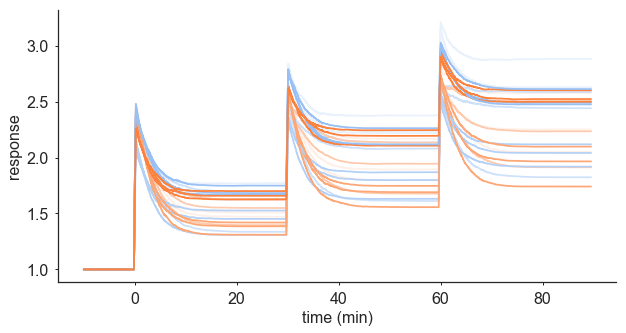

In [30]:
from lfimodels.moran.moranFunctions_v3 import run_sequential_ltp

obs = utils.LTP_obs_data(rec=rec_condition1[0])
t = obs['time']

fig = plt.figure(figsize=(10,5))

for k in range(min_num_subset):
    print(k)
    # simulate and plot samples
    for i in range(num_samp_subset):

        # parameters not fitted. Some with variability
        num_synapse = np.random.randint(900,1100)
        num_receptors = np.random.randint(90,110)
        param_fixed = [100, num_synapse, num_receptors, 1.0] #time_plast, num_synapse, num_receptors, gifit

        # numerical simulation
        simulation_condition1  = run_sequential_ltp(param_fixed, list(posterior_samples_condition1_3sets[i,:,k]))
        response_condition1 = simulation_condition1['wholetraj']/simulation_condition1['wholetraj'][0]
        simulation_condition2  = run_sequential_ltp(param_fixed, list(posterior_samples_condition2_3sets[i,:,k]))
        response_condition2 = simulation_condition2['wholetraj']/simulation_condition2['wholetraj'][0]
        
        
        # plot numerical simulations
#         plt.subplot(4,5,k+1)
        t_sim_condition1 = np.linspace(t[0],t[-1],len(response_condition1))
        t_sim_condition2 = np.linspace(t[0],t[-1],len(response_condition2))
        plt.plot(t_sim_condition1,response_condition1,col_condition1[k])
        plt.plot(t_sim_condition2,response_condition2,col_condition2[k])

        if i==num_samp_subset-1:
            plt.xlabel('time (min)')
            plt.ylabel('response')

#     ax = plt.gca()
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc='upper right');